# A Titanic Questions
----------------------------
##  Analysing the Passengers and Survivors of the Titanic


### Selena Flannery -- November 17, 2016

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [2]:
filename = "data/titanic_data.csv"

titanic = pd.read_csv(filename)
titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Get rid of columns that won't have any correlation -- ID number, cabin number, ticket number'

In [3]:
titanic = titanic.drop(labels=["Cabin", "Ticket", "PassengerId"], axis=1)

## Data Munging

Which columns have NaN values?

In [4]:
for c in titanic.columns:
    print(c, titanic[c].hasnans)

Survived False
Pclass False
Name False
Sex False
Age True
SibSp False
Parch False
Fare False
Embarked True


The Age Column and the Embarked Column has NaNs....We will have to deal with this

Let's look at the Age Column

In [5]:
print("Total Rows Where Age is Null: ", sum(pd.isnull(titanic.Age)))

Total Rows Where Age is Null:  177


Ugh. That is a lot of missing data

In [6]:
titanic.Age = titanic.Age.fillna(titanic.Age.mean())
print("Total Rows Where Age is Null: ", sum(pd.isnull(titanic.Age)))

Total Rows Where Age is Null:  0


What does the Embarked column look like?

In [7]:
print("Unique Embarked Values: ", titanic.Embarked.unique())
print("Total Rows Null: ", sum(pd.isnull(titanic.Embarked)))

Unique Embarked Values:  ['S' 'C' 'Q' nan]
Total Rows Null:  2


In [8]:
southampton = titanic.Embarked == "S"
queenstown = titanic.Embarked == "Q"
cherbourg = titanic.Embarked == "C"



In [9]:
bins = np.linspace(0, 300, 100)

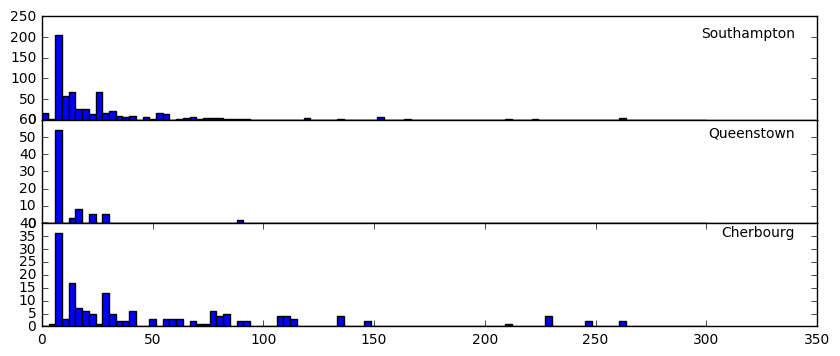

In [10]:
fig = plt.figure(figsize=(10,4))
fig.subplots_adjust(hspace=0)
plt.subplot(3, 1, 1)
plt.hist(titanic[southampton].Fare, bins=bins)
plt.text(340, 200, "Southampton", horizontalalignment="right")
plt.xticks([])

plt.subplot(3, 1, 2)
plt.hist(titanic[queenstown].Fare, bins=bins)
plt.text(340, 50, "Queenstown", horizontalalignment="right")
plt.xticks([])

plt.subplot(3, 1, 3)
plt.hist(titanic[cherbourg].Fare, bins=bins)
plt.text(340, 35, "Cherbourg", horizontalalignment="right")

plt.show()

Most passengers embarked at southhampton, but if their ticket price was high the passenger seems to have come from Cherbourg, and if their ticket price was low they boarded at Queenstown

In [11]:
def fill_Embarked(x):
    if pd.isnull(x.Embarked):
        fare = x.Fare
        if fare <= 20:
            return "Q"
        elif fare > 50:
            return "C"
        else:
            return "S"
    return x.Embarked

In [12]:
# This works, but seems messy
# titanic.Embarked = [fill_Embarked(titanic.loc[i]) for i in range(len(titanic))]

In [13]:
titanic.apply(fill_Embarked, axis=1)
sum(pd.isnull(titanic.Embarked))

2

## Rescaling our Data

Let's make our data a little easier to compare.

In [14]:
def rescale(xval, xdata):
    """Rescale xval with respect to all of the xdata"""
    top = xval - min(xdata)
    bottom = max(xdata) - min(xdata)
    return top/bottom

In [15]:
titanic.Age[0]

22.0

In [16]:
rescale(titanic.Age[0], titanic.Age)

0.27117366172405127

In [17]:
rescale(titanic.Fare[0], titanic.Fare)

0.014151057562208049

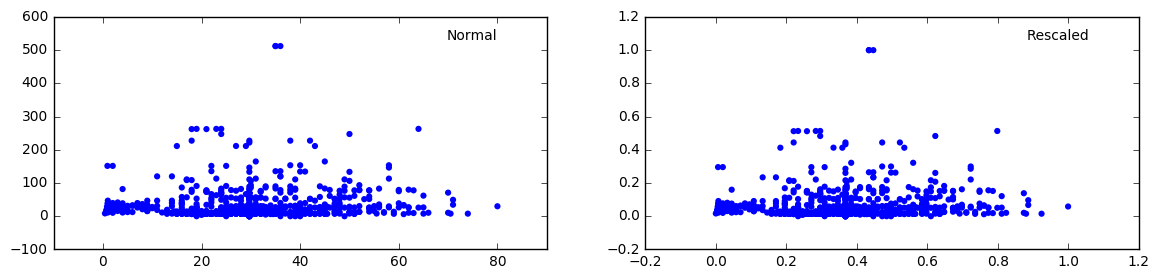

In [18]:
plt.figure(figsize=(14, 3))
ax = plt.subplot(1, 2, 1) # before
ax.scatter(titanic.Age, titanic.Fare, edgecolor="None")
ax.text(0.9, 0.9, "Normal", transform=ax.transAxes, horizontalalignment="right")

ax = plt.subplot(1, 2, 2) # after
ax.scatter(rescale(titanic.Age, titanic.Age), rescale(titanic.Fare, titanic.Fare), edgecolor="None")
ax.text(0.9, 0.9, "Rescaled", transform=ax.transAxes, horizontalalignment="right")

plt.show()

These look approximately the same, but the x and y scale are more easily compared

### Rescale Data with Sci Kit Learn

Transform data to a zero to 1 scale

In [19]:
scaler = MinMaxScaler()

scaler.fit_transform(titanic.Age.reshape(-1, 1))

array([[ 0.27117366],
       [ 0.4722292 ],
       [ 0.32143755],
       [ 0.43453129],
       [ 0.43453129],
       [ 0.36792055],
       [ 0.67328474],
       [ 0.01985423],
       [ 0.33400352],
       [ 0.17064589],
       [ 0.04498618],
       [ 0.72354863],
       [ 0.24604172],
       [ 0.48479517],
       [ 0.17064589],
       [ 0.68585072],
       [ 0.01985423],
       [ 0.36792055],
       [ 0.3842674 ],
       [ 0.36792055],
       [ 0.43453129],
       [ 0.42196532],
       [ 0.18321186],
       [ 0.34656949],
       [ 0.09525006],
       [ 0.4722292 ],
       [ 0.36792055],
       [ 0.23347575],
       [ 0.36792055],
       [ 0.36792055],
       [ 0.49736115],
       [ 0.36792055],
       [ 0.36792055],
       [ 0.8240764 ],
       [ 0.34656949],
       [ 0.52249309],
       [ 0.36792055],
       [ 0.25860769],
       [ 0.22090978],
       [ 0.17064589],
       [ 0.49736115],
       [ 0.33400352],
       [ 0.36792055],
       [ 0.03242021],
       [ 0.23347575],
       [ 0

Never. Pass. NaNs. To. Sci. Kit. Learn.

## Classification and K Nearest Neighbors

Target: Survivability!

Natural Categories:
    Embarked,
    Survived,
    Pclass

In [20]:
clf = KNeighborsClassifier()

clf.fit(titanic[["Age", "Fare"]], titanic.Survived)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [21]:
titanic["age_scaled"] = scaler.fit_transform(titanic.Age.reshape(-1, 1))
titanic["fare_scaled"] = scaler.fit_transform(titanic.Fare.reshape(-1, 1))

In [22]:
clf.fit(titanic[["age_scaled", "fare_scaled"]], titanic.Survived)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

## Train Data

In [24]:
x_train, x_test, y_train, y_test = train_test_split(titanic[["age_scaled", "fare_scaled"]], titanic.Survived, test_size=0.33)

In [26]:
clf = KNeighborsClassifier()
clf.fit(x_train, y_train)

y_model = clf.predict(x_test)

### Accuracy Score

In [27]:
from sklearn.metrics import accuracy_score

In [28]:
accuracy_score(y_test, y_model) # Truth compared to output of the model

0.69830508474576269

## Cross Validation

Making sure that the classifier is not overfit on data.

Dividing data into sets for training and sets for testing.

Kfold. 1 = test set, n -1 = training set

In [30]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=4)
kf.get_n_splits(titanic)

5

In [31]:
for train_index, test_index in kf.split(titanic):
    X_train = titanic[["age_scaled", "fare_scaled"]].loc[train_index]
    X_test = titanic[["age_scaled", "fare_scaled"]].loc[test_index]

    y_train = titanic.Survived.loc[train_index]
    y_test = titanic.Survived.loc[test_index]

    clf.fit(X_train, y_train)
    y_model = clf.predict(X_test)
    print("accuracy: ", accuracy_score(y_test, y_model))

accuracy:  0.597765363128
accuracy:  0.64606741573
accuracy:  0.651685393258
accuracy:  0.685393258427
accuracy:  0.702247191011


In [41]:
avg_accuracy = []

In [42]:
for k in range(1, 41):
    clf = KNeighborsClassifier(n_neighbors=k)
    accuracies = []
    kf = KFold(n_splits=5, random_state=4, shuffle=True)
    kf.get_n_splits(titanic)

    for train_index, test_index in kf.split(titanic):
         X_train = titanic[["age_scaled", "fare_scaled"]].loc[train_index]
         X_test = titanic[["age_scaled", "fare_scaled"]].loc[test_index]

         y_train = titanic.Survived.loc[train_index]
         y_test = titanic.Survived.loc[test_index]

         clf.fit(X_train, y_train)
         y_model = clf.predict(X_test)
         accuracies.append(accuracy_score(y_test, y_model))

    avg_accuracy.append(np.mean(accuracies))

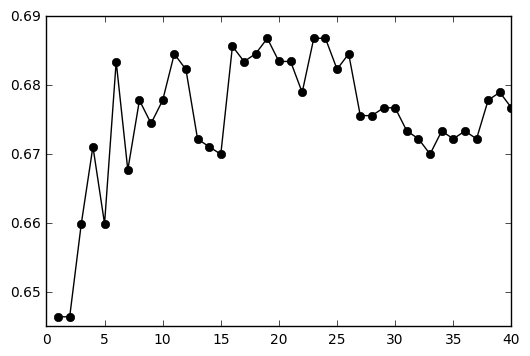

In [45]:
plt.plot(range(1, 41), avg_accuracy, 'ko-')
plt.show()